In [4]:
!pip install shap lime xgboost lightgbm --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Step 1: Upload CSV from your local machine
from google.colab import files
uploaded = files.upload()



Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [7]:
# Step 1: Upload CSV from your local machine
from google.colab import files
uploaded = files.upload()

import os

# Get the actual filename from the uploaded dictionary
# Assuming only one file was uploaded, you can get the first key
if uploaded:
    original_filename = list(uploaded.keys())[0]
    # Rename the uploaded file to 'Telco-Customer-Churn.csv'
    os.rename(original_filename, 'Telco-Customer-Churn.csv')
    print(f"File '{original_filename}' renamed to 'Telco-Customer-Churn.csv'")
else:
    print("No file was uploaded.")

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
File 'WA_Fn-UseC_-Telco-Customer-Churn.csv' renamed to 'Telco-Customer-Churn.csv'


Initial Data Shape: (7043, 21)

Logistic Regression:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Random Forest:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407


XGBoost:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      1033
           1       0.57      0.47      0.51       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68   

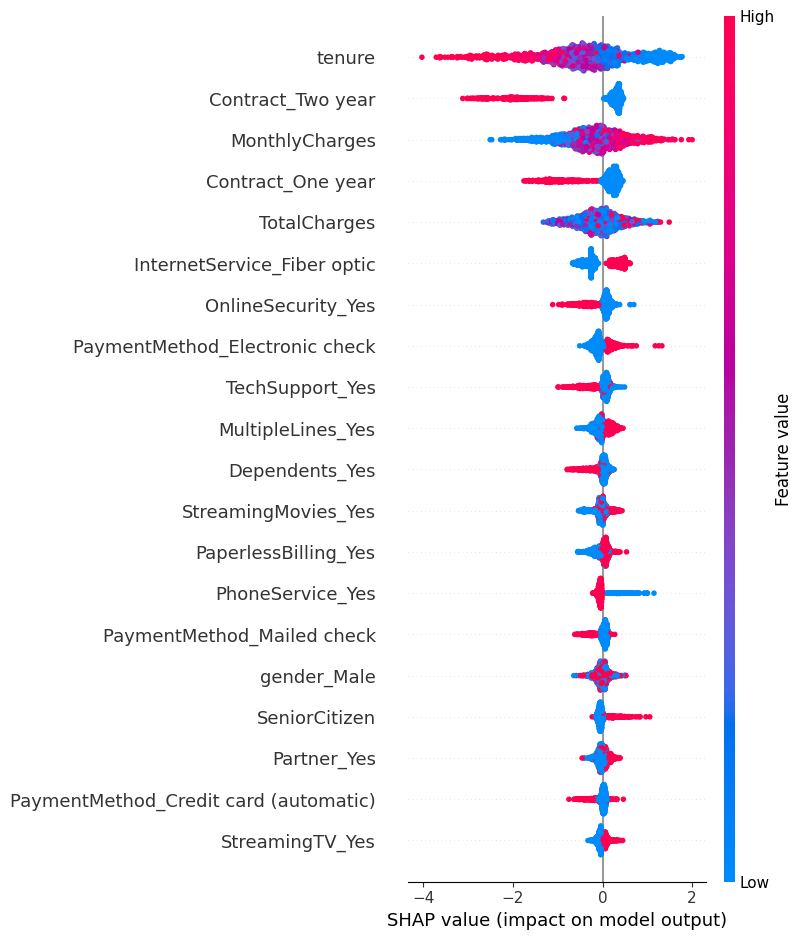

In [8]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

# Step 1: Load Data
df = pd.read_csv('Telco-Customer-Churn.csv')  # Adjusted file name
print("Initial Data Shape:", df.shape)

# Step 2: Data Preprocessing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()
df.drop('customerID', axis=1, inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Step 3: Train-Test Split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Training & Evaluation

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\nLogistic Regression:\n", classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest:\n", classification_report(y_test, y_pred_rf))

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost:\n", classification_report(y_test, y_pred_xgb))

# Step 5: SHAP Model Interpretation
print("\nGenerating SHAP values...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
